# Packages 

In [30]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

## Importer les données

In [2]:
with open('data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)

## 1. Analyse de la forme

### 1.1. Première impression globale

In [3]:
dat

{'X_train':             0         1         2         3         4         5         6    \
 28553 -0.107712  0.202686 -0.036410 -0.538686  0.162234 -0.109034 -0.075343   
 6286   0.056359  0.003188 -0.726052 -0.616777  0.064091 -0.068786  0.384864   
 36284 -0.331249  0.210670 -0.202662 -0.654994  0.307785 -0.254564 -0.165728   
 12083 -0.565799  0.118481  0.185003 -0.692792 -0.056820  0.039130  0.241766   
 7859  -0.669160 -0.052143 -0.708578 -0.159049 -0.273591  0.059959 -0.134847   
 ...         ...       ...       ...       ...       ...       ...       ...   
 6265  -0.477219 -0.340833  0.164393 -0.458924  0.052212 -0.441877  0.169248   
 11284 -0.357661 -0.081198  0.371942 -0.535762  0.083119 -0.410523  0.307964   
 38158 -0.510303 -0.441524 -0.445965 -0.568472 -0.319142  0.211381  0.438302   
 860   -0.183741 -0.053005 -0.181491 -0.876436 -0.257675  0.030207  0.487837   
 15795 -0.270753  0.010459 -0.206073 -0.748081 -0.095389 -0.006112  0.334259   
 
             7         8   

In [4]:
print(type(dat))

<class 'dict'>


In [6]:
for key, value in dat.items():
    print(f"Type de données de {key}: {type(value)}")

Type de données de X_train: <class 'pandas.core.frame.DataFrame'>
Type de données de X_test: <class 'pandas.core.frame.DataFrame'>
Type de données de Y: <class 'pandas.core.series.Series'>
Type de données de S_train: <class 'pandas.core.series.Series'>
Type de données de S_test: <class 'pandas.core.series.Series'>


Les features sont des dataFrames : bidimensionnelle avec des index étiquetés.
Le reste s'agit de séries : unidimensionnelle. 

Afin de faciliter notre analyse, on doit se procéder à une décomposition des données

### 1.2. Décomposition et Calcul du pourcentage de répartition des échantillons

In [8]:
# Features
X_train = dat['X_train']
X_test = dat['X_test'] 

# Données à prédire
Y_train = dat['Y']

# Attributs sensibles
S_train = dat['S_train']
S_test = dat['S_test']

In [11]:
total = len(X_train) + len(X_test)
pourcentage_train = len(X_train) / total
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_train :", Y_train.shape)
print("S_train :", S_train.shape)
print("S_test :", S_test.shape)
print("nombre total d'observations:", total) 
print("pourcentage de X_train:", pourcentage_train)

X_train: (27749, 768)
X_test: (11893, 768)
Y_train : (27749,)
S_train : (27749,)
S_test : (11893,)
nombre total d'observations: 39642
pourcentage de X_train: 0.6999899096917411


La base de données de départ contient alors les éléments suivants : 
- **X_train** est un dataframe contenant les features pour l'entraînement. Il a 27749 nombre d'observations et 768 variables.

- **X_test** est aussi un dataframe qui contient les features pour le test. Il a moins de nombre d'observations avec 11893 mais avec le même nombre de variable que X_train. En gros, on peut observer qu'environ 70% des échantillons sont dans X_train et le reste pour le test. C'est une bonne répartition vu la taille élevée des données.

- **Y** contient les étiquettes (labels) pour toutes les données. Y signifie ici Y_train, il a le même nombre d'observation que X_train. Par contre, on ne sait pas le Y_test puisqu'il sera à prédire. **Pour ne pas éviter une confusion, on peut changer Y en Y_train. **

- **S_train** et **S_test** sont les attributs sensibles (par exemple, le genre) pour les ensembles d'entraînement et de test.

### 1.4. Vérification des NA

In [12]:
# Comptage du nombre de NA dans la base de données
nombre_NA = {}

for key, value in dat.items():
    if isinstance(value, pd.DataFrame):
        # Compter les NA pour chaque colonne dans un DataFrame
        nombre_NA[key] = value.isna().sum().sum()  # Somme des NA dans tout le DataFrame
    elif isinstance(value, pd.Series):
        # Compter les NA dans une Series
        nombre_NA[key] = value.isna().sum()

# Afficher le nombre de NA pour chaque composant de dat
for key, na_count in nombre_NA.items():
    print(f"Nombre de NA dans {key}: {na_count}")

Nombre de NA dans X_train: 0
Nombre de NA dans X_test: 0
Nombre de NA dans Y: 0
Nombre de NA dans S_train: 0
Nombre de NA dans S_test: 0


C'est une bonne nouvelle. Nos données sont toutes complètes. Par conséquent, on peut passer à une analyse de fonds maintenant

### 1.5. Vérification de la standartisation des variables d'entrainement

Chaque variable standartisée suit les propriétés suivantes : 
- moyenne = 0
- écart_type = 1
A prtir de cette propriété, on va chercher si les variables sont standartisées.

In [14]:
stat_normal = X_train.aggregate(['mean', 'std'])

In [15]:
# vérifier l'intervalle si x appartient à [0, 1]
intervalle = (X_train.min() >= 0) & (X_train.max() <= 1)

# Cette étape considère une variable comme standartisée si sa moyenne est proche de 0 et son écart-type proche de 1
normalise = stat_normal.loc['mean'].abs().lt(0.01) & stat_normal.loc['std'].between(0.99, 1.01)

# Compter le nombre de variables qui ne respectent pas l'intervalle [0, 1]
num_variables_dehors_intervalle = (~intervalle).sum()

# Compter le nombre de variables qui ne sont pas considérées comme standartisées 
num_variables_non_normalise = (~normalise).sum()

In [16]:
num_variables_dehors_intervalle , num_variables_non_normalise

(768, 768)

L'ensemble des features ne sont pas centrés et réduite. Ils sont centrés ou réduites?  

In [18]:
centree = stat_normal.loc['mean'].abs().lt(0.01)
num_variables_non_centrees = (~centree).sum()
reduite = stat_normal.loc['std'].between(0.99, 1.01)
num_variables_non_reduite = (~reduite).sum()

print("nombre de variables non centrées:", num_variables_non_centrees)
print("nombre de variables non réduites:", num_variables_non_reduite)

nombre de variables non centrées: 748
nombre de variables non réduites: 768


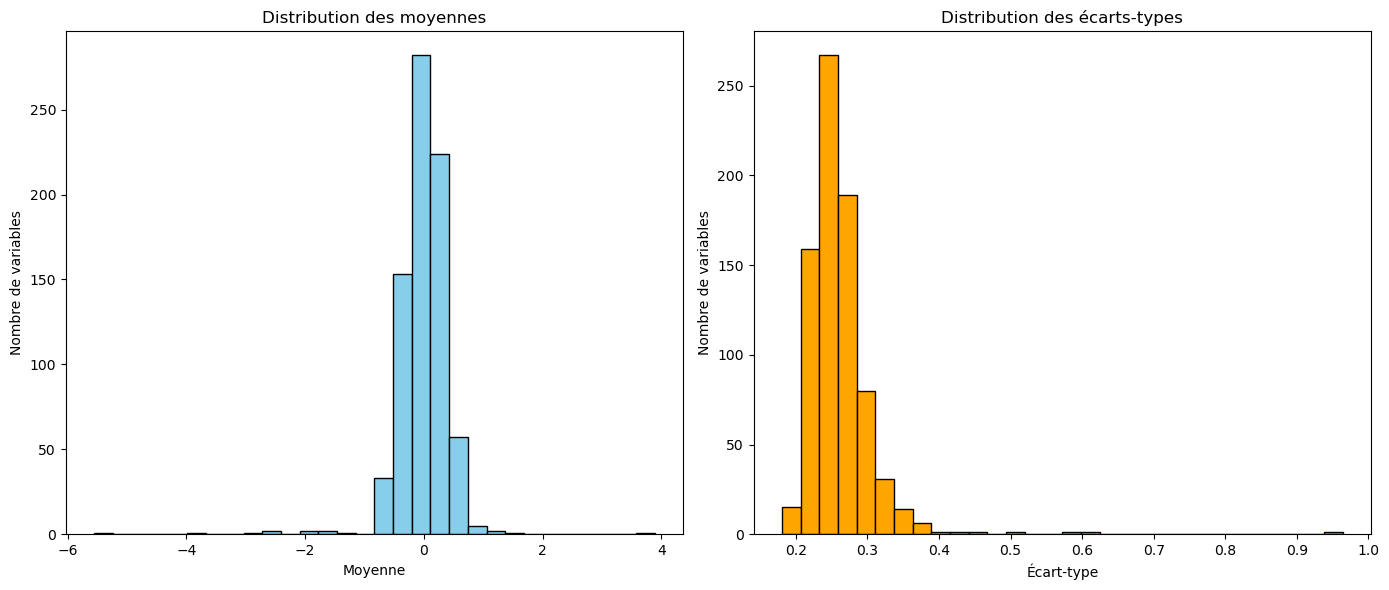

In [19]:
# Illustration graphique
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, 1er graphique
plt.hist(stat_normal.loc['mean'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution des moyennes')
plt.xlabel('Moyenne')
plt.ylabel('Nombre de variables')

# Créer un histogramme pour les écarts-types
plt.subplot(1, 2, 2) # 1 ligne, 2 colonnes, 2ème graphique
plt.hist(stat_normal.loc['std'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution des écarts-types')
plt.xlabel('Écart-type')
plt.ylabel('Nombre de variables')

plt.tight_layout()
plt.show()

**Histogramme des Moyennes :** La distribution montre une tendance centrée autour de zéro, conforme à la standardisation. Cependant, certaines variables présentent des moyennes significativement éloignées de zéro, suggérant une non-standardisation

**Histogramme des Écarts-Types :** La plupart des variables ont des écarts-types inférieurs à 1 mais sont éloignées.

Les variables ne sont donc pas standartisées. 

### 1.6. Vérification de la standartisation des variables de test 

In [20]:
stat_normal_test = X_test.aggregate(['mean', 'std'])

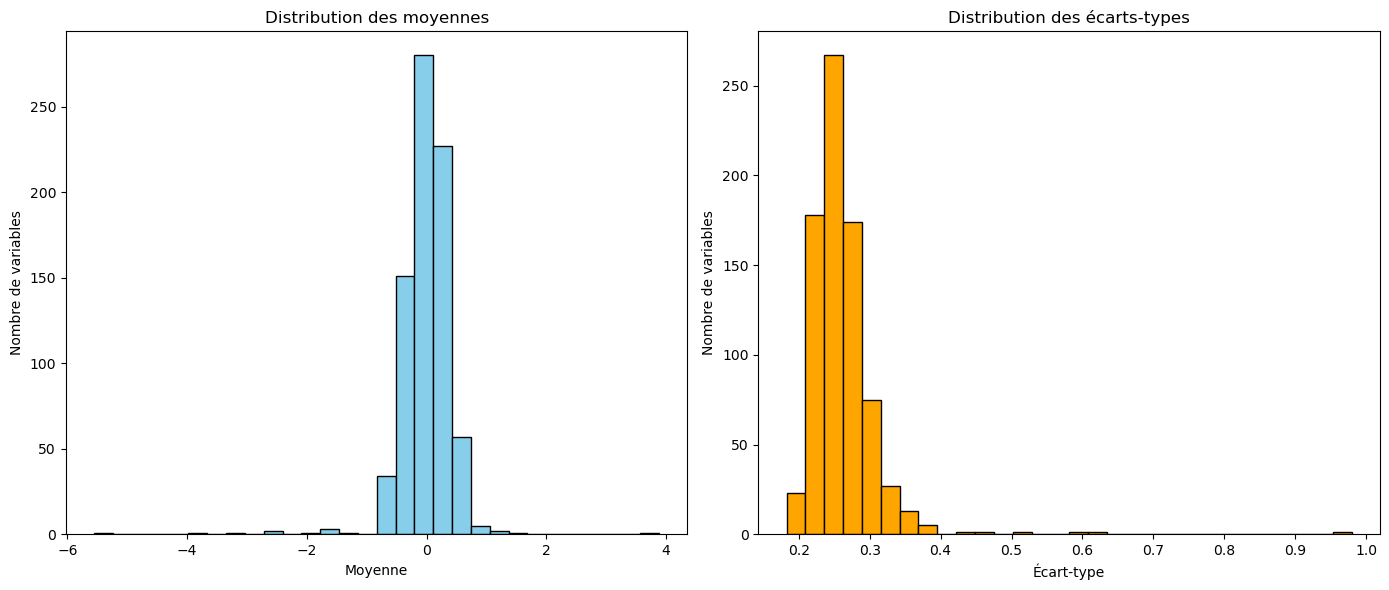

In [21]:
# Illustration graphique
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) # 1 ligne, 2 colonnes, 1er graphique
plt.hist(stat_normal_test.loc['mean'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution des moyennes')
plt.xlabel('Moyenne')
plt.ylabel('Nombre de variables')

# Créer un histogramme pour les écarts-types
plt.subplot(1, 2, 2) # 1 ligne, 2 colonnes, 2ème graphique
plt.hist(stat_normal_test.loc['std'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution des écarts-types')
plt.xlabel('Écart-type')
plt.ylabel('Nombre de variables')

plt.tight_layout()
plt.show()

Même observation pour le test. Il faut ajouter que la distribution de X_test est très semblable à X_train.

## 2. Analyse de fonds

### 2.1. Analyse du target

#### Question : 
- Les classes représentent quoi? 
- Est-ce qu'il y a certains classes plus représentés dans les données que d'autres? 

In [23]:
Y_train.value_counts()

21    8285
19    2918
2     2273
18    1715
11    1402
13    1316
22    1295
26    1121
6      994
25     948
1      703
14     542
12     524
20     504
9      499
24     467
0      387
5      386
7      262
4      206
3      184
16     178
15     136
27     115
8      107
17      97
10      93
23      92
Name: profession_class, dtype: int64

Quand on parle de classification de texte, on fait référence à la profession des personnes. Ainsi, par anticipation la tâche ici est de détecter la profession d'une personne à partir de ses caractéristiques. Nous avons vu aussi combien de personnes se situent dans chaque classe.

Cette distribution montre le nombre d'observations par classe de profession dans notre ensemble de données, où chaque classe est identifiée par un numéro (par exemple, 21, 19, 2, etc.)
La classe 21 detient plus d'un quart des observations. 
Le top 03 de notre classification est 21, 19 et 2. Ce sont les valeurs qui concident avec plus de 2000 personnes. Le top 8 detiennent à chacun plus de 1000 personnes. A partir de là, il y a une dégression des valeurs jusqu'à 92 personnes uniquement pour la classe 23.

Nous pouvons déjà comprendre que nos données detiennent un **grand déséquilibre des classes**. Une telle information influence nécessairement la stratégie de modélisation. 

Pour faciliter la compréhension, on utilise un graphique sous format de pourcentage. 

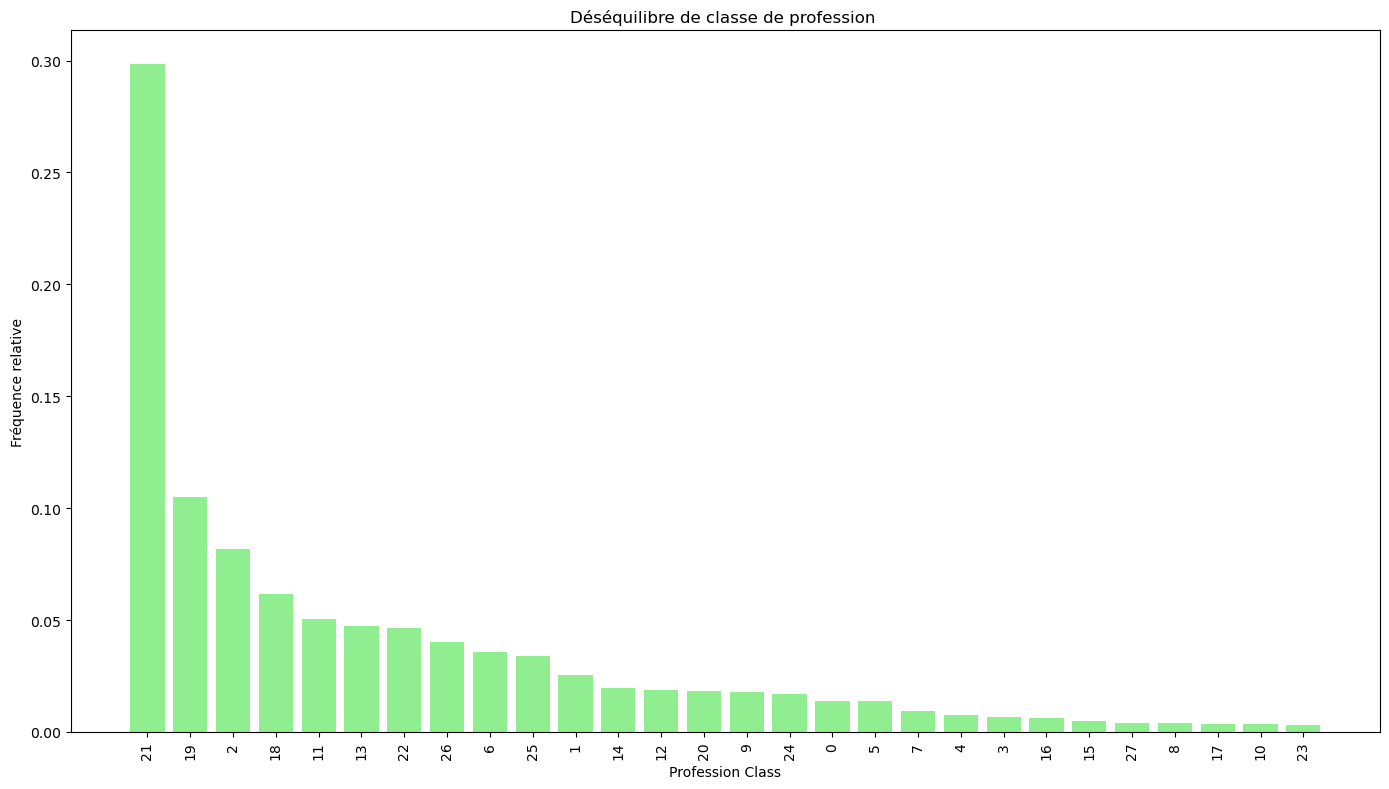

In [24]:
# Calcul de la fréquence relative, triée par valeur et non par index
frequence_relative = Y_train.value_counts(normalize=True).sort_values(ascending=False)

# Création du graphique
fig, ax = plt.subplots(figsize=(14, 8))

# Index pour les classes de profession, basé sur l'ordre trié
classes = np.arange(len(frequence_relative))

# Graphique pour les fréquences relatives
ax.bar(classes, frequence_relative, width=0.8, color='lightgreen')

# Mise en forme
ax.set_xlabel('Profession Class')
ax.set_ylabel('Fréquence relative')
ax.set_title('Déséquilibre de classe de profession ')
ax.set_xticks(classes)

# Définir les étiquettes de l'axe x pour correspondre aux classes originales, dans l'ordre de fréquence
ax.set_xticklabels(frequence_relative.index)
plt.xticks(rotation=90)  # Rotation des étiquettes pour une meilleure lisibilité

plt.tight_layout()  # Ajustements automatiques de la mise en page
plt.show()

Le déséquilibre dans la variable cible peut vraiment conduire à des modèles de prédictions biaisés. En effet, il y a un Biais envers la classe majoritaire. Le modèle futur serait biaisé en faveur de la classe la plus représentée dans la variable cible, réduisant ainsi sa capacité à identifier correctement les instances de la classe minoritaire.

Sans ce précipiter, voyons si le genre est corrélé avec la variable cible et n'est pas distribué équitablement. Dans ce cas, le modèle peut apprendre à associer certaines professions à un genre spécifique, ce qui pourrait mener à des prédictions discriminatoires.

## 2. Relation entre le target et le genre

### 2.1. Analyse du genre

In [ ]:
#### Questions : 
- La répartition entre les femmes et les hommes dans les données est-elle équilibrée ?"
- Y a-t-il une dépendance entre le genre et la profession ?

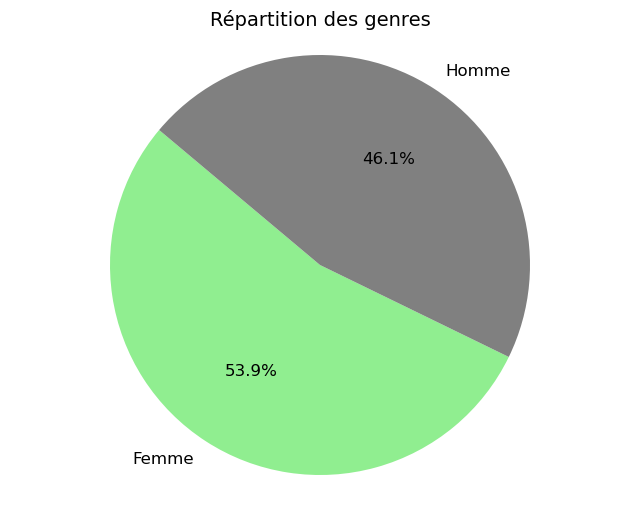

In [25]:
# Compter les occurrences de chaque classe dans la série
counts = S_train.value_counts()

# Créer un diagramme en camembert
# Définir les couleurs
colors = ['lightgreen', 'grey']

# Créer un diagramme en camembert
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=['Femme', 'Homme'], autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
plt.title('Répartition des genres', fontsize=14)
plt.axis('equal')
plt.show()

Même si la différence n'est énorme, on peut voir que les femmes ont un nombre élevé un peu élevé. Cet déséquilibre s'accompagne-t-elle de la dépendance avec les professions? 

### 2.2. Création d'un tableau croisé

In [27]:
df_profession_gender = pd.concat([Y_train, S_train], axis=1)
df_profession_gender.columns = ['Profession', 'Genre']
df_profession_gender

,Profession,Genre
28553,6,0
6286,9,1
36284,6,0
12083,22,1
7859,21,0
...,...,...
6265,19,1
11284,13,1
38158,12,1
860,22,1


In [28]:
# Tableau croisé de la profession et du genre
cross_table = pd.crosstab(df_profession_gender['Profession'], df_profession_gender['Genre'])

# Afficher le tableau croisé
print(cross_table)

Genre          0     1
Profession            
0            237   150
1            540   163
2           1382   891
3            128    56
4            160    46
5            324    62
6            652   342
7             22   240
8             92    15
9            347   152
10            14    79
11           717   685
12            93   431
13           127  1189
14           286   256
15            21   115
16           132    46
17            55    42
18          1113   602
19          1462  1456
20           258   246
21          4559  3726
22           494   801
23            83     9
24           391    76
25           805   143
26           441   680
27            21    94


### 2.3. Illustration graphique de la dépendance

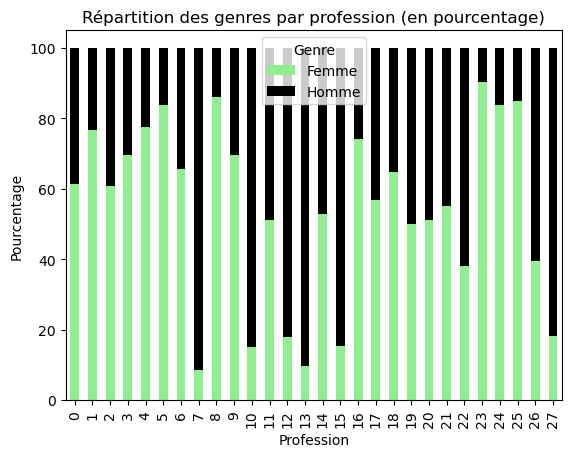

In [29]:
# Calculer le nombre total d'individus par profession
total_by_profession = cross_table.sum(axis=1)

# Diviser chaque valeur dans le tableau croisé par le nombre total d'individus par profession
cross_table_percent = cross_table.div(total_by_profession, axis=0) * 100

# Création d'un graphique à barres
cross_table_percent.plot(kind='bar', stacked=True, color=['lightgreen', 'black'])
plt.title('Répartition des genres par profession (en pourcentage)')
plt.xlabel('Profession')
plt.ylabel('Pourcentage')
plt.xticks(rotation=90)
plt.legend(['Femme', 'Homme'], title='Genre')
plt.show()

Graphiquement, on peut voir pour certaines professions, il y a une différence notable dans les pourcentages des genres. A titre d'exemple significatif, pour la classe 5, 8, 23 et 25 on observe une nette domination des femmes. Par contre, pour les professions 7, 10, 12, 13, 15, 27 il y plus de 80% des hommes. il y a une prédominance significative d'un genre par rapport à l'autre, cela pourrait être un indicateur d'une tendance ou d'une association entre le genre et la profession. 

Faions une vérification avec un test statistique si ces dépendances sont significatives. 

### 2.4. Vérification de la dépendance avec le test de Chi-deux

**Hypothèses**
H0 : Il n'y a pas d'association entre le genre et la profession. Cela signifie que la distribution des genres serait similaire dans toutes les professions.

H1 : Il existe une association entre le genre et la profession. Cela signifierait que la distribution des genres varie entre les professions.

**Test Statistique**
Le test du chi-carré est utilisé pour comparer les fréquences observées des genres dans différentes professions avec les fréquences attendues si le genre et la profession étaient indépendants. Les étapes du test sont les suivantes :

1- Calculer les fréquences attendues pour chaque combinaison de genre et de profession en supposant l'indépendance.

2- Calculer la statistique de chi-carré en sommant les carrés des différences entre les fréquences observées et attendues, divisées par les fréquences attendues.

3- Comparer la statistique de chi-carré calculée avec la valeur critique de la distribution du chi-carré avec le nombre approprié de degrés de liberté (dans ce cas, 27).

In [31]:
chi2, p, dof, expected = chi2_contingency(cross_table)
chi2, p, dof

(3229.383757882848, 0.0, 27)

Compte tenu de la valeur p de 0.0 très faible, nous rejetons l'hypothèse nulle. Il y a donc suffisamment de preuves pour conclure qu'il existe une association significative entre le genre et la profession. Cette relation est statistiquement significative, ce qui implique que le genre peut être un facteur influent dans la distribution des individus à travers différentes professions.

## 3. Stratégie de modélisation 

### 3.1. Récapitulatif de l'exploration de données

Finalement, voici les informations très utiles dans la modélisation :
- target : profession (qualitative)
- features : quantitatives
- Même si le nombre de variables sont relativement élevées (768), ils sont moins faible que le nombre d'observations (plus de 20000).
- Pas de NA
- Attention aux algorithmes qui utilisent des variables standartisées, il faut standartiser les features.
- le déséquilibre des classes pour le target
- la relation entre le target et une variable sensible (le gender) 
- le léger déséquilibre de la classe d'hommes (46%) et femmes (54%)

Du coup, il est essentiel d'agir sur le déséquilibre de classe et la discrimination.
Quelle est notre solution? 

### 3.2. Méthode documentaire et principe suivi

La première étape à faire à ce niveau a été la méthode documentaire. Il s'agit de lire quelles sont les solutions proposées dans la littérature pour résoudre ces problèmes. Les solutions sont variées tournant autour de pre-processing comme le rééchantillonage, la répondération puis le processing où on peut voir la solution comme l'optimisation équitable à travers les résularisations, et enfin le post-processing notamment le seuillage et la calibration. Chacune de ces améliorations nécessite un temps non négligeable pour chaque modèle. C'est ainsi qu'on a essayé d'établir une stratégie de diversité sans se perdre dans les détails. Dans ce sens, il y a un article de base qu'on a suivi : http://repository.unisi.ac.id/41/.

Sans entrer en détails dans cet article, la démarche que l'on peut y tirer est la suivante : 
- Introduction de la Diversité lors de l'Entraînement : Chaque modèle de l'ensemble est entraîné séparément, en introduisant de la diversité à travers différents mécanismes. Ces mécanismes incluent 
  - l'utilisation de différentes valeurs initiales et paramètres,
  - l'expérimentation avec diverses architectures de modèles, 
  - l'application de techniques d'apprentissage variées (Simple modèle, le boosting, le bagging, ....), 
  - la manipulation des données d'entraînement (par exemple, en utilisant des sous-ensembles aléatoires de données ou des techniques de rééchantillonnage, SMOTE, ....), 
  - et la manipulation des caractéristiques d'entrée (comme l'utilisation de sous-ensembles aléatoires de caractéristiques). ---  
- Chacune de ces méthodes vise à faire en sorte que les modèles apprennent à partir de perspectives différentes, traitent les données de manière unique, ou se concentrent sur différents aspects des données, ce qui augmente la diversité au sein de l'ensemble.

- Nature de biais et orientation : **La parité démographique** dans le cadre de mon modèle de prédiction d'emploi cherche à assurer que les genres soient représentés équitablement dans chaque catégorie d'emploi prédite, indépendamment de leur proportion dans les données réelles. Si par exemple, 50% des candidats prédits pour un poste sont des femmes, alors les femmes devraient constituer 50% des prédictions pour tous les emplois, quelle que soit leur représentation dans le jeu de données. C'est une approche qui vise à neutraliser l'influence du genre sur les prédictions. En choisissant la parité démographique comme mesure d'équité, j'oriente mon modèle pour favoriser une diversité représentative. Cela permet de s'assurer que le genre ne joue pas un rôle dans les prédictions d'emploi. Ainsi, on vise une représentation équilibrée des genres dans les résultats, sans égard à leur distribution dans les données d'entraînement.


### 3.3. Comment s'y prendre concrètement : 

- Constitution des données 
- Lancement des modèles de classifications les plus utilisés dans la littératures sans préréglages : 
  - régression logistique
  - SVM linéaire sans normalisation de données
  - SGDClassifier
  - OneVSoneClassifierSGDClassifier
  - OneVSrestClassifierSGDClassifier
  - randomforest
  - réseaux de neuronnes
  - classifieur naif de bayes
- Choix des trois modèles qui s'adaptent le mieux aux données
- Entrainement un à un de ces modèles en introduisant la diversité susmentionnée
- Ensemble learning des trois méthodes